# 4. 컬러매칭 파이프라인

## 4-1. 라이브러리 불러오기

In [1]:
from PIL import Image
import joblib
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import HTML, display

In [2]:
# 정규화된 값을 원래의 RGB 형태로 변환하는 함수
def convert_to_original(data):
    return tuple(np.array(data) * 255.0)

def convert_to_numeric(data):
    # RGB 값들을 0에서 1 사이의 실수 값으로 정규화
    return np.array([np.array(rgb) / 255.0 for rgb in data])


def kmeans_find_major_color(image):
    pixels = np.array(image)[:, :, :3].reshape((-1, 3))
    kmeans = KMeans(n_clusters=1, n_init=10, random_state=42)
    kmeans.fit(pixels)

    if kmeans.cluster_centers_ is not None and len(kmeans.cluster_centers_) > 0:
        dominant_color = tuple(map(int, kmeans.cluster_centers_[0]))
        return dominant_color
    else:
        return None

def extract_colors_from_bboxes(resized_image, bboxes):
    result_df = pd.DataFrame(columns=['TOP_RGB', 'BOTTOM_RGB'])

    for idx, bbox in enumerate(bboxes):
        class_label = idx  # 예제에서는 클래스 레이블을 간단하게 인덱스로 사용합니다.

        # 주요 색상 추출
        cropped_image = resized_image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

        major_color = kmeans_find_major_color(cropped_image)

        # 주요 색상과 클래스 레이블을 DataFrame에 추가
        if major_color is not None:
            if class_label == 0:
                result_df.loc[0, 'TOP_RGB'] = major_color
            elif class_label == 1:
                result_df.loc[0, 'BOTTOM_RGB'] = major_color
        else:
            # 주요 색상이 없는 경우 출력하지 않음
            continue

    return result_df

def show_color(rgb):
    color_str = f'rgb({rgb[0]}, {rgb[1]}, {rgb[2]})'
    display(HTML(f'<div style="width:100px; height:100px; background-color:{color_str};"></div>'))

def extract_major_colors(image_path, model_path, resize=(400, 500)):
    # YOLOv5 모델 로드
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  

    # 이미지 열기
    image = Image.open(image_path)

    # 원하는 크기로 이미지 리사이징
    resized_image = image.resize(resize)

    # 객체 검출 수행
    results_resized = model(resized_image)

    # 바운딩 박스 좌표 추출
    bboxes = [detection[0:4].cpu().numpy().astype(int) for detection in results_resized.xyxy[0]]

    # 바운딩 박스 좌표와 주요 색상 추출
    result_df = extract_colors_from_bboxes(resized_image, bboxes)

    return result_df, results_resized

## 4-2.파이프라인 구축

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# 가장 비슷한 색상 클러스터 찾기 함수
def find_nearest_cluster(result_df, cluster_df):
    # result_df에서 상의와 하의 색상 추출
    major_colors = [
        ("Top", result_df.loc[0, 'TOP_RGB']),
        ("Bottom", result_df.loc[0, 'BOTTOM_RGB'])
    ]
    
    cluster_centers = np.array(cluster_df['Representative_Color'].tolist())
    nearest_clusters = []

    for class_label, color in major_colors:
        if pd.isna(color):  # 색상이 없는 경우 건너뜁니다.
            continue
        color_arr = np.array(color).reshape(1, -1)
        closest_idx, _ = pairwise_distances_argmin_min(color_arr, cluster_centers)
        
        nearest_cluster_info = {
            "Class": class_label,
            "Detected_Color": color,
            "Nearest_Cluster": cluster_df.iloc[closest_idx[0]]['Top_RGB_Cluster'],
            "Representative_Color": cluster_df.iloc[closest_idx[0]]['Representative_Color'],
            "Bottom_RGB_List": cluster_df.iloc[closest_idx[0]]['Bottom_RGB_List']
        }
        
        nearest_clusters.append(nearest_cluster_info)
    
    return nearest_clusters

def plot_color_palette(rgb_list, title="Recommended Bottom Wear Color Palette", save_path="palette.png"):
    if not rgb_list:
        print("Error: RGB list is empty.")
        return

    fig, ax = plt.subplots(figsize=(len(rgb_list), 2))
    for i, rgb in enumerate(rgb_list):
        color = [x / 255.0 for x in rgb]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

    ax.set_xlim(0, len(rgb_list))
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title(title)
    
    # 파일로 저장
    plt.savefig(save_path, format="png")
    print(f"Palette saved to {save_path}")
    plt.close(fig)
    
# 주요 색상 및 가장 가까운 클러스터 정보 출력 및 하의 팔레트 시각화
def color_extraction_pipeline(image_path, model_path, cluster_df):
    # 주요 색상 추출
    result_dataframe, results_resized = extract_major_colors(image_path, model_path)
    
    # 상의 색상과 가장 가까운 클러스터 찾기
    nearest_clusters = find_nearest_cluster(result_dataframe, cluster_df)
    
    # 각 주요 색상에 대한 클러스터 정보 출력 및 팔레트 시각화
    for cluster_info in nearest_clusters:
        # Class가 "Top"인 경우에만 시각화
        if cluster_info['Class'] != 'Top':
            continue
        
        results_resized.show()
        print(f"탐지된 {cluster_info['Class']} 색상: {cluster_info['Detected_Color']}")
        show_color(cluster_info['Detected_Color'])
        print(f"가장 가까운 클러스터: {cluster_info['Nearest_Cluster']}")
        print(f"대표 색상: {cluster_info['Representative_Color']}")
        print(f"추천 하의 팔레트: {cluster_info['Bottom_RGB_List']}")
        
        # Bottom_RGB_List 값을 이용해 시각화 함수 호출
        bottom_rgb_list = cluster_info['Bottom_RGB_List']
        plot_color_palette(bottom_rgb_list, title="Recommended Bottom Wear Color Palette for Top Color")


## 4-3. 컬러 팔레트 리스트 불러오기

In [4]:
bottom_rgb_lists= pd.read_csv('/data1/project/seoeun/BAF/색상추출/bottom_rgb_list.csv')

In [5]:
# bottom_rgb_lists의 'Representative_Color'와 'Bottom_RGB_List' 열을 튜플 및 리스트로 변환
bottom_rgb_lists['Representative_Color'] = bottom_rgb_lists['Representative_Color'].apply(eval)
bottom_rgb_lists['Bottom_RGB_List'] = bottom_rgb_lists['Bottom_RGB_List'].apply(eval)


## 4-4. 최종 결과물

In [6]:
# 모델 경로 및 이미지 경로 설정
model_path = '/data1/project/seoeun/BAF/색상추출/yolov5/runs/train/best_yolov5s_result2/weights/best.pt'

Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


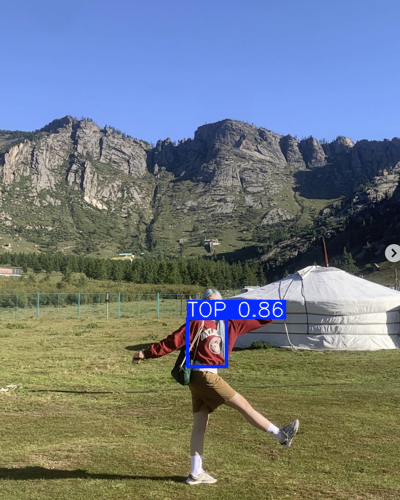

탐지된 Top 색상: (134, 93, 89)


가장 가까운 클러스터: 77
대표 색상: (136, 106, 86)
추천 하의 팔레트: [(95, 113, 109), (162, 138, 108), (52, 59, 67)]
Palette saved to palette.png


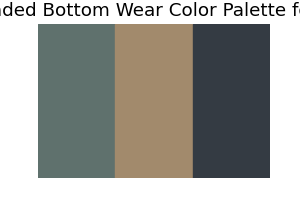

In [7]:
image_path = '/data1/project/seoeun/BAF/색상추출/test5.png'

# 파이프라인 실행
color_extraction_pipeline(image_path, model_path, bottom_rgb_lists)

Image.open("palette.png")


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


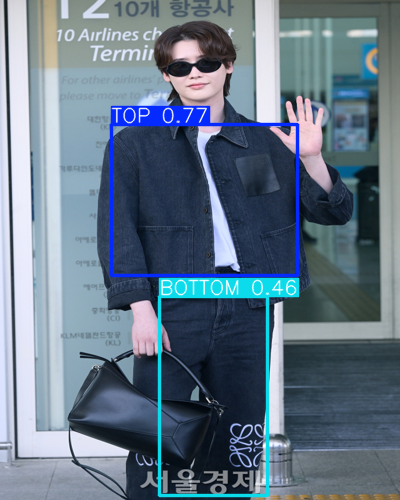

탐지된 Top 색상: (50, 64, 87)


가장 가까운 클러스터: 47
대표 색상: (52, 73, 84)
추천 하의 팔레트: [(204, 211, 208), (33, 42, 48), (109, 132, 137), (167, 189, 184), (135, 136, 124)]
Palette saved to palette.png


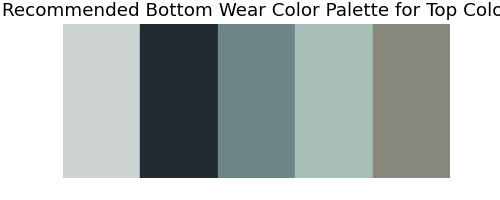

In [17]:
# 모델 경로 및 이미지 경로 설정
image_path = '/data1/project/seoeun/BAF/색상추출/test9.jpg'

# 파이프라인 실행
color_extraction_pipeline(image_path, model_path, bottom_rgb_lists)

Image.open("palette.png")


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


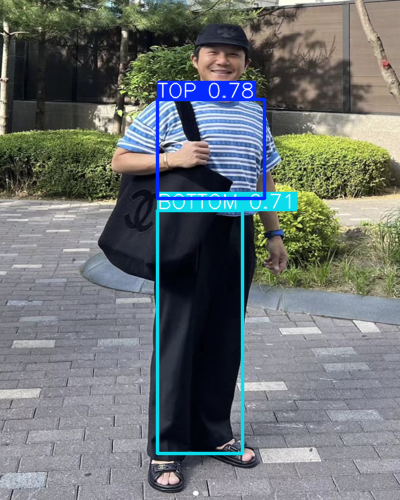

탐지된 Top 색상: (108, 120, 145)


가장 가까운 클러스터: 107
대표 색상: (116, 123, 141)
추천 하의 팔레트: [(53, 57, 53), (147, 151, 148), (45, 47, 44), (93, 113, 124), (97, 124, 141), (84, 91, 95), (99, 118, 119)]
Palette saved to palette.png


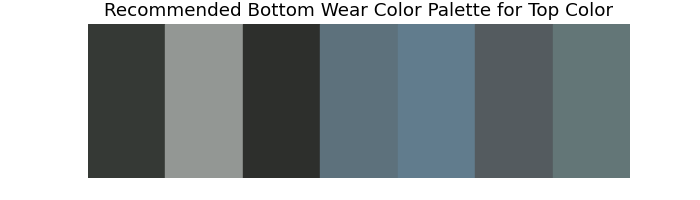

In [22]:
# 모델 경로 및 이미지 경로 설정
image_path = '/data1/project/seoeun/BAF/색상추출/test26.png'

# 파이프라인 실행
color_extraction_pipeline(image_path, model_path, bottom_rgb_lists)

Image.open("palette.png")